<a href="https://colab.research.google.com/github/kavya2299/Credit-Card-Fraud-Detection-/blob/main/Credit_Card_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing all the packages


In [1]:
import pandas as pd # data processing
import numpy as np # working with arrays
import matplotlib.pyplot as plt # visualization
from termcolor import colored as cl # text customization
import itertools # advanced tools
import seaborn as sns
import sklearn

#from sklearn.preprocessing import StandardScaler # data normalization
#from sklearn.model_selection import train_test_split # data split
#from sklearn.tree import DecisionTreeClassifier # Decision tree algorithm
from sklearn.neighbors import LocalOutlierFactor 
#from sklearn.linear_model import LogisticRegression # Logistic regression algorithm
from sklearn.svm import OneClassSVM # SVM algorithm
from sklearn.ensemble import IsolationForest 
#from xgboost import XGBClassifier # XGBoost algorithm

from sklearn.metrics import confusion_matrix # evaluation metric
from sklearn.metrics import classification_report, accuracy_score # evaluation metric
from sklearn.metrics import f1_score # evaluation metric

In [2]:
from pylab import rcParams
rcParams["figure.figsize"] = 14, 8
RANDOM_SEED = 42
LABELS = ["Fair", "Fraud"]

# Downloading data from Kaggle

In [3]:
! pip install -q kaggle
from google.colab import files
files.upload()
#Make directory named kaggle and copy kaggle.json file there.
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

Saving kaggle.json to kaggle.json
ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              216KB  2021-03-21 11:36:30            664  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-02-17 16:10:44            536  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-02-18 10:08:27            560  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19            228  
fatiimaezzahra/famous-iconic-women        

In [4]:
! kaggle datasets download -d mlg-ulb/creditcardfraud

 74% 49.0M/66.0M [00:01<00:00, 19.4MB/s]
100% 66.0M/66.0M [00:01<00:00, 41.0MB/s]


In [5]:
! unzip creditcardfraud.zip -d complete

Archive:  creditcardfraud.zip
  inflating: complete/creditcard.csv  


# Importing data from the drive

In [6]:
# creating a dataframe of variables
df = pd.read_csv("/content/complete/creditcard.csv")
pd.set_option('display.max_columns', 100)
print(df.head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10       V11       V12       V13       V14  \
0  0.098698  0.363787  0.090794 -0.551600 -0.617801 -0.991390 -0.311169   
1  0.085102 -0.255425 -0.166974  1.612727  1.065235  0.489095 -0.143772   
2  0.247676 -1.514654  0.207643  0.624501  0.066084  0.717293 -0.165946   
3  0.377436 -1.387024 -0.054952 -0.226487  0.178228  0.507757 -0.287924   
4 -0.270533  0.817739  0.753074 -0.822843  0.538196  1.345852 -1.119670   

        V15       V16       V17       V18       V19       V20 

# Data Preprocessing

In [7]:
no_of_cases = len(df)
fair_count = len(df[df.Class == 0])
fraud_count = len(df[df.Class == 1])
fraud_percentage = round(fraud_count/fair_count*100, 2)

print(cl('CASE COUNT', attrs = ['bold']))
print(cl('--------------------------------------------', attrs = ['bold']))
print(cl('Total number of cases are {}'.format(no_of_cases), attrs = ['bold']))
print(cl('Number of Fair cases are {}'.format(fair_count), attrs = ['bold']))
print(cl('Number of Fraudulent cases are {}'.format(fraud_count), attrs = ['bold']))
print(cl('Percentage of fraud cases is {}'.format(fraud_percentage), attrs = ['bold']))
print(cl('--------------------------------------------', attrs = ['bold']))

CASE COUNT
--------------------------------------------
Total number of cases are 284807
Number of Fair cases are 284315
Number of Fraudulent cases are 492
Percentage of fraud cases is 0.17
--------------------------------------------


So, we understand that it is an imbalanced dataset. Now, we move further based on the amount of transactions in the two cases.


In [8]:
fraud = df[df.Class == 1]
fair = df[df.Class == 0]

In [9]:
print(cl('CASE AMOUNT STATISTICS', attrs = ['bold']))
print(cl('--------------------------------------------', attrs = ['bold']))
print(cl('FAIR CASE AMOUNT STATS', attrs = ['bold']))
print(fair.Amount.describe())
print(cl('--------------------------------------------', attrs = ['bold']))
print(cl('FRAUD CASE AMOUNT STATS', attrs = ['bold']))
print(fraud.Amount.describe())
print(cl('--------------------------------------------', attrs = ['bold']))

CASE AMOUNT STATISTICS
--------------------------------------------
FAIR CASE AMOUNT STATS
count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64
--------------------------------------------
FRAUD CASE AMOUNT STATS
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64
--------------------------------------------


Further visualizing the amounts of the two types of transactions, we get the following:

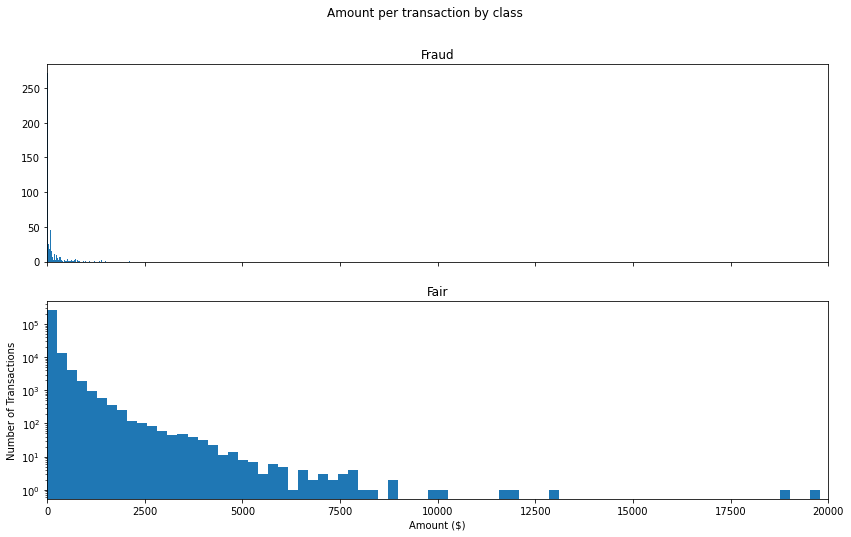

In [10]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')
bins = 100
ax1.hist(fraud.Amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(fair.Amount, bins = bins)
ax2.set_title('Fair')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show()

We plot the amounts with respect to the time of transaction to observe a pattern.

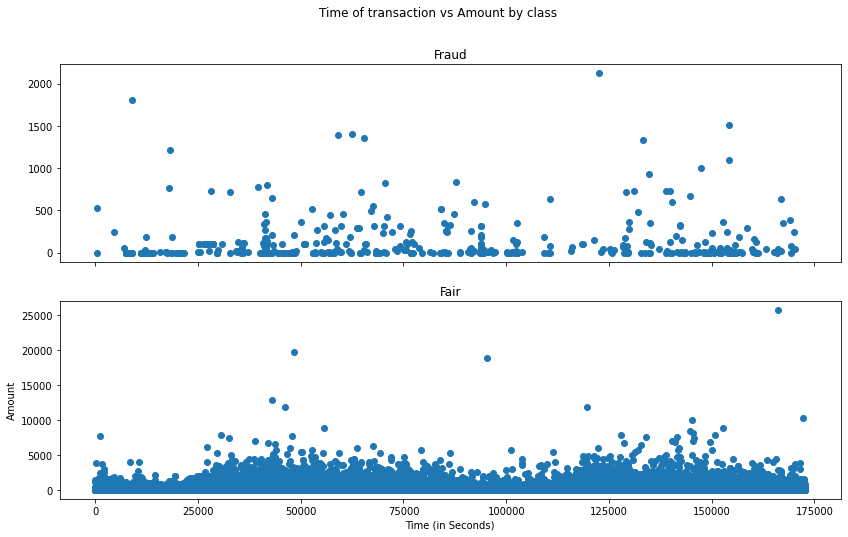

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')
ax1.scatter(fraud.Time, fraud.Amount)
ax1.set_title('Fraud')
ax2.scatter(fair.Time, fair.Amount)
ax2.set_title('Fair')
plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

Looking at the above plots, we are unable to note a pattern. Hence, we move on further.

# Model Prediction

In [11]:
#Create independent and Dependent Features
columns = df.columns.tolist()
# Filter the columns to remove data we do not want 
columns = [c for c in columns if c not in ["Class"]]
# Store the variable we are predicting 
target = "Class"
# Define a random state 
state = np.random.RandomState(42)
X = df[columns]
Y = df[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
# Print the shapes of X & Y
print(X.shape)
print(Y.shape)

(284807, 30)
(284807,)


In [13]:
outlier_fraction = len(fraud)/float(len(fair))
clf = IsolationForest(n_estimators=100, max_samples=len(X), contamination=outlier_fraction,random_state=state, verbose=0)


In [20]:
n_outliers = len(fraud)
clf.fit(X)
scores_prediction = clf.decision_function(X)
y_pred = clf.predict(X)
#Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1
n_errors = (y_pred != Y).sum()

In [23]:
# Run Classification Metrics
print("{}".format(n_errors))
print("Accuracy Score : {}".format(accuracy_score(Y,y_pred)))
#print(accuracy_score(Y,y_pred))
print("Classification Report :")
print(classification_report(Y,y_pred))

669
Accuracy Score : 0.9976510408803154
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.32      0.32      0.32       492

    accuracy                           1.00    284807
   macro avg       0.66      0.66      0.66    284807
weighted avg       1.00      1.00      1.00    284807

